### MSc in CSTE, CIDA option's Advanced Python & Advanced Java Assignment

In [1]:
from sklearn.exceptions import ConvergenceWarning
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d as plt3d
import numpy as np
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from tabulate import tabulate

class MultiLinearRegression:

    def __init__(self, filename, predColIndexes, targetColIndex, iterations, learningRate):
        # Read data from file:
        self.filename = filename

        # Load data, remove first row (columns names), remove nan values and normalize it:
        self.columnsNames = np.genfromtxt(self.filename, delimiter=',', dtype=str, max_rows=1)
        self.data = np.genfromtxt(self.filename, delimiter=',', skip_header=1)
        self.data = self.data[~np.isnan(self.data).any(axis=1)]
        self.data = preprocessing.scale(self.data)

        # Split data into features and target, and add a column of ones to features:
        self.Y = self.data[:, targetColIndex]
        self.data = self.data[:, predColIndexes]
        self.data = np.insert(self.data, 0, 1, axis=1)

        # Number of features and observations:
        self.r = len(self.data[0])  # number of features
        self.n = len(self.data)  # number of observations

        # Initialize thetas, hypothesis, iterations and learning rate:
        self.thetas = np.ones(self.r)  # initialize thetas
        self.hypothesis = np.zeros(self.n)  # initialize hypothesis
        self.iterations = iterations
        self.learningRate = learningRate

        # Cost:
        self.cost = []

    # Print amount features and observations:
    def printInfo(self):
        print('Features: ', self.r)
        print('Observations: ', self.n)

    # Plot data with different colors for each feature:
    def plotData(self):
        colors = ['purple', 'red', 'blue', 'orange', 'grey']
        for i in range(self.r - 1):
            plt.scatter(self.data[:, i], self.Y, color=colors[i], marker='o', s=1, label=self.columnsNames[i])
            plt.title('Energy output (EP) vs ' + self.columnsNames[i])
            plt.legend()
        plt.show()

    # Plot features:
    def plotFeatures(self):
        for i in range(self.r - 1):
            plt.scatter(self.data[:, i], self.Y, color='grey', marker='o', s=1, label=self.columnsNames[i])
            plt.title('Energy output (EP) vs ' + self.columnsNames[i])
            plt.legend()
            plt.show()

    # Plot each feature's prediction line using thetas:
    def plotFeaturesAndTheirPredictionLine(self):
        for i in range(self.r - 1):
            plt.scatter(self.data[:, i], self.Y, color='grey', marker='o', s=1, label=self.columnsNames[i])
            plt.plot(self.data[:, i], self.thetas[i]*self.data[:, i], color='red', label='Prediction line')
            plt.title('Energy output (EP) vs ' + self.columnsNames[i])
            plt.legend()
            plt.show()

    # Cost function:
    def costFunction(self):
        return (1 / self.n) * np.sum(np.square(self.hypothesis - self.Y))

    # Gradient descent:
    def gradientDescent(self):
        cost = []
        for i in range(self.iterations):
            self.hypothesis = np.dot(self.data, self.thetas)
            for j in range(self.r):
                self.thetas[j] -= self.learningRate * (2 / self.n) * np.sum((self.hypothesis - self.Y) * self.data[:, j])
            cost.append(self.costFunction())
        self.cost = cost
        return cost

    # Gradient descent using multiples train and test sets:
    def gradientDescentMultipleTrainAndTestSets(self, proportion):
        # Split data into train and test sets:
        trainData = self.data[0:int(self.n * proportion)]
        trainY = self.Y[0:int(self.n * proportion)]
        testData = self.data[int(self.n * proportion):]
        testY = self.Y[int(self.n * proportion):]

        # Initialize thetas, hypothesis, iterations and learning rate:
        thetas = np.ones(self.r)  # initialize thetas
        hypothesis = np.zeros(len(trainData))  # initialize hypothesis
        iterations = self.iterations
        learningRate = self.learningRate

        # Cost:
        cost = []
        for i in range(iterations):
            hypothesis = np.dot(trainData, thetas)
            for j in range(self.r):
                thetas[j] -= learningRate * (2 / len(trainData)) * np.sum((hypothesis - trainY) * trainData[:, j])
            cost.append(1 / len(trainData) * np.sum(np.square(hypothesis - trainY)))
        cost = cost
        r2 = 1 - (np.sum(np.square(testY - np.dot(testData, thetas))) / np.sum(np.square(testY - np.mean(testY))))

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=ConvergenceWarning)
            reg = make_pipeline(StandardScaler(), SGDRegressor(max_iter=self.iterations, eta0=self.learningRate))
            reg.fit(trainData, trainY)

        return cost, r2, reg.score(trainData, trainY)


    # Gradient descent while thetas successive differences are greater than 0.0001:
    def gradientDescentUntilConvergence(self):
        cost = []
        thetas = np.zeros(self.r)
        while np.sum(np.abs(thetas - self.thetas)) > 0.0001:
            thetas = np.copy(self.thetas)
            self.hypothesis = np.dot(self.data, self.thetas)
            for j in range(self.r):
                self.thetas[j] -= self.learningRate * (2 / self.n) * np.sum((self.hypothesis - self.Y) * self.data[:, j])
            cost.append(self.costFunction())
        self.cost = cost
        return cost

    # Plot cost:
    def plotCost(self):
        plt.plot(self.cost, label='cost evolution, itr=' + str(self.iterations)+', eta='+str(self.learningRate))
        plt.title('\''+self.filename+'\'')
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.legend()
        plt.show()

    # Compute R2:
    def computeR2(self):
        return 1 - np.sum(np.square(self.hypothesis - self.Y)) / (self.n*np.var(self.Y))

    # Print R2:
    def printR2(self):
        print('Computed R2 for the ' + self.filename + ' data, in percentage: ', str(np.round(self.computeR2()*100, 2)), ' %')

    # Compute SKLearn gradient descent R2 choosing learning rate and iterations using SGDRegressor:
    def computeSKLearnR2(self):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=ConvergenceWarning)
            reg = make_pipeline(StandardScaler(), SGDRegressor(max_iter=self.iterations, eta0=self.learningRate))
            reg.fit(self.data, self.Y)
            return reg.score(self.data, self.Y)

    # Print SKLearn gradient descent R2:
    def printSKLearnR2(self):
        print('SKLearn R2 for the ' + self.filename + ' data, in percentage: ', str(np.round(self.computeSKLearnR2()*100, 2)), ' %')

ModuleNotFoundError: No module named 'sklearn'

In [3]:
# Plot multiple plots in one figure:
def plotMultiple(filename, predColIndexes, targetColIndex, iterations, learningRates):
    fig, axs = plt.subplots(4, 4)
    fig.suptitle(filename+' : Cost for various iterations and learning rates values.')
    for i in range(len(learningRates)):
        for j in range(len(iterations)):
            mlr = MultiLinearRegression(filename, predColIndexes, targetColIndex, iterations[j], learningRates[i])
            mlr.gradientDescent()
            axs[i, j].plot(mlr.cost, label='itr=' + str(iterations[j]) + ', eta=' + str(learningRates[i]))
            axs[i, j].set_xlabel('Iterations')
            axs[i, j].set_ylabel('Cost')
            axs[i, j].text(0.35, 0.25, 'R2: ' + str(round(mlr.computeR2(), 2)), horizontalalignment='center',
                           verticalalignment='center', transform=axs[i, j].transAxes)
            axs[i, j].legend()
    fig.set_size_inches(16.5, 10.5)
    fig.subplots_adjust(top=0.93)
    plt.show()

# 3D plot of R2 for various iterations and learning rates values with contour plot:
def plot3D(filename, predColIndexes, targetColIndex, iterations, learningRates):
    fig = plt.figure()
    ax = plt3d.Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Learning rate')
    ax.set_zlabel('R2')
    ax.set_title(filename)
    X, Y = np.meshgrid(iterations, learningRates)
    Z = np.zeros((len(learningRates), len(iterations)))
    for i in range(len(learningRates)):
        for j in range(len(iterations)):
            mlr = MultiLinearRegression(filename, predColIndexes, targetColIndex, iterations[j], learningRates[i])
            mlr.gradientDescent()
            Z[i, j] = mlr.computeR2()
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='cool', edgecolor='black')
    ax.view_init(30, 230)
    ax.text2D(0.22, 0.95, 'Computation of R**2 for various iterations and eta values', transform=ax.transAxes)
    plt.show()


# Table of R2 for various iterations and learning rates values using tabulate:
def tableOfR2(filename, predColIndexes, targetColIndex, iterations, learningRates):
    table = []
    for i in range(len(learningRates)):
        row = [learningRates[i]]
        for j in range(len(iterations)):
            mlr = MultiLinearRegression(filename, predColIndexes, targetColIndex, iterations[j], learningRates[i])
            mlr.gradientDescent()
            row.append(round(mlr.computeR2(), 4))
        table.append(row)
    print(filename+' : Table of R2 for various iterations and learning rates values:')
    print(tabulate(table, headers=['LR \ ITR'] + iterations, tablefmt='fancy_grid'))

# Print max R2 for various iterations and learning rates values, at .01 % precision:
def printMaxR2(filename, predColIndexes, targetColIndex, iterations, learningRates):
    maxR2 = 0
    maxR2Index = [0, 0]
    for i in range(len(learningRates)):
        for j in range(len(iterations)):
            mlr = MultiLinearRegression(filename, predColIndexes, targetColIndex, iterations[j], learningRates[i])
            mlr.gradientDescent()
            if mlr.computeR2() - maxR2 > 0.0001:
                maxR2 = mlr.computeR2()
                maxR2Index = [i, j]
    print(filename+' : Max R2: ', np.round(maxR2*100,2), ' % (for itr=', iterations[maxR2Index[1]], ', and eta=', learningRates[maxR2Index[0]], ')')


# Table of iterations needed for convergence for various learning rates values using tabulate:
def tableOfIterations(filename, predColIndexes, targetColIndex, learningRates):
    table = []
    for i in range(len(learningRates)):
        mlr = MultiLinearRegression(filename, predColIndexes, targetColIndex, 100000, learningRates[i]) # Iterations parameter is not important here
        mlr.gradientDescentUntilConvergence()
        table.append([learningRates[i], len(mlr.cost)])
    print(filename+' : Table of iterations needed for convergence, for various learning rates values:')
    print(tabulate(table, headers=['Learning rate', 'Iterations'], tablefmt='fancy_grid'))

# Table of difference between computed R2 and SKlearn R2, for various iterations and learning rates values using tabulate:
def tableOfR2Diff(filename, predColIndexes, targetColIndex, iterations, learningRates):
    table = []
    for i in range(len(learningRates)):
        row = [learningRates[i]]
        for j in range(len(iterations)):
            mlr = MultiLinearRegression(filename, predColIndexes, targetColIndex, iterations[j], learningRates[i])
            mlr.gradientDescent()
            row.append(str(abs(round((mlr.computeR2() - mlr.computeSKLearnR2())*100, 2))) + ' %')
        table.append(row)
    print(filename+' : Table of difference between computed R2 and SKlearn R2, for various iterations and learning rates values:')
    print(tabulate(table, headers=['LR \ ITR'] + iterations, tablefmt='fancy_grid'))

In [4]:
# Files and their predictor and target columns indexes:
files = [['dataEnergy.csv', [0, 1, 2, 3], 4], ['dataLoans.csv', [1, 4], 0]]

In [5]:
for file in files:
    # Create MultiLinearRegression object by referencing the data, predictor and target columns; as well as the number of iterations and learning rate:
    mlr = MultiLinearRegression(file[0], file[1], file[2], 1000, 0.01)
    # Compute gradient descent:
    mlr.gradientDescent()

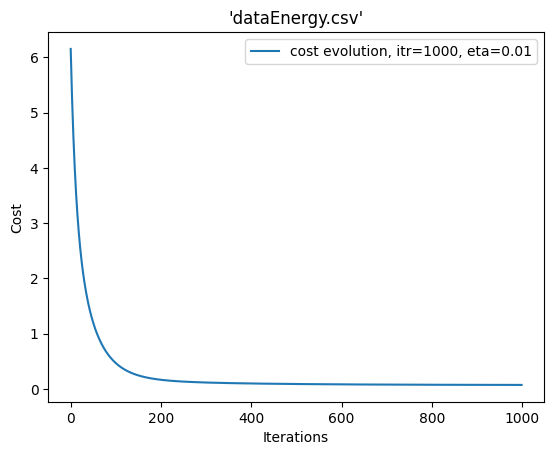

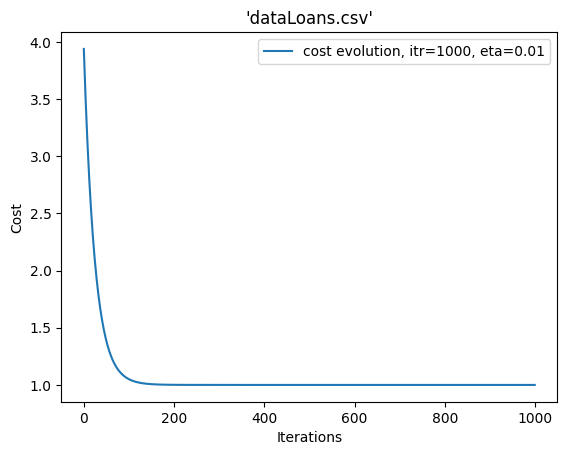

In [17]:
for file in files:
    # Plot its cost:
    mlr = MultiLinearRegression(file[0], file[1], file[2], 1000, 0.01)
    mlr.gradientDescent()
    mlr.plotCost()

In [340]:
for file in files:
    mlr = MultiLinearRegression(file[0], file[1], file[2], 1000, 0.01)
    mlr.gradientDescent()
    # Print its R2:
    mlr.printR2()

Computed R2 for the dataEnergy.csv data, in percentage:  92.63  %
Computed R2 for the dataLoans.csv data, in percentage:  0.09  %


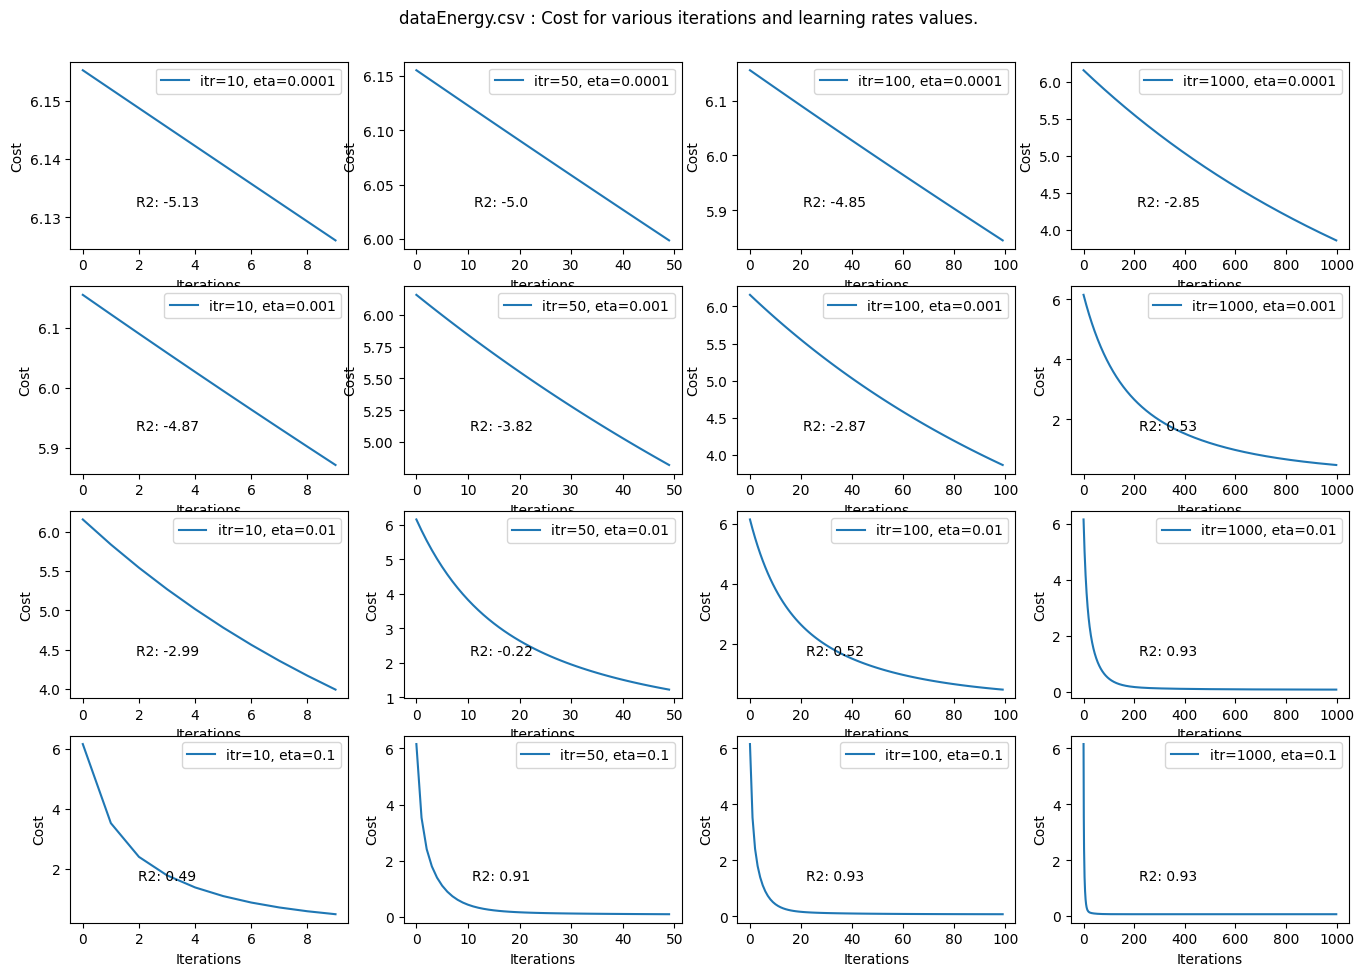

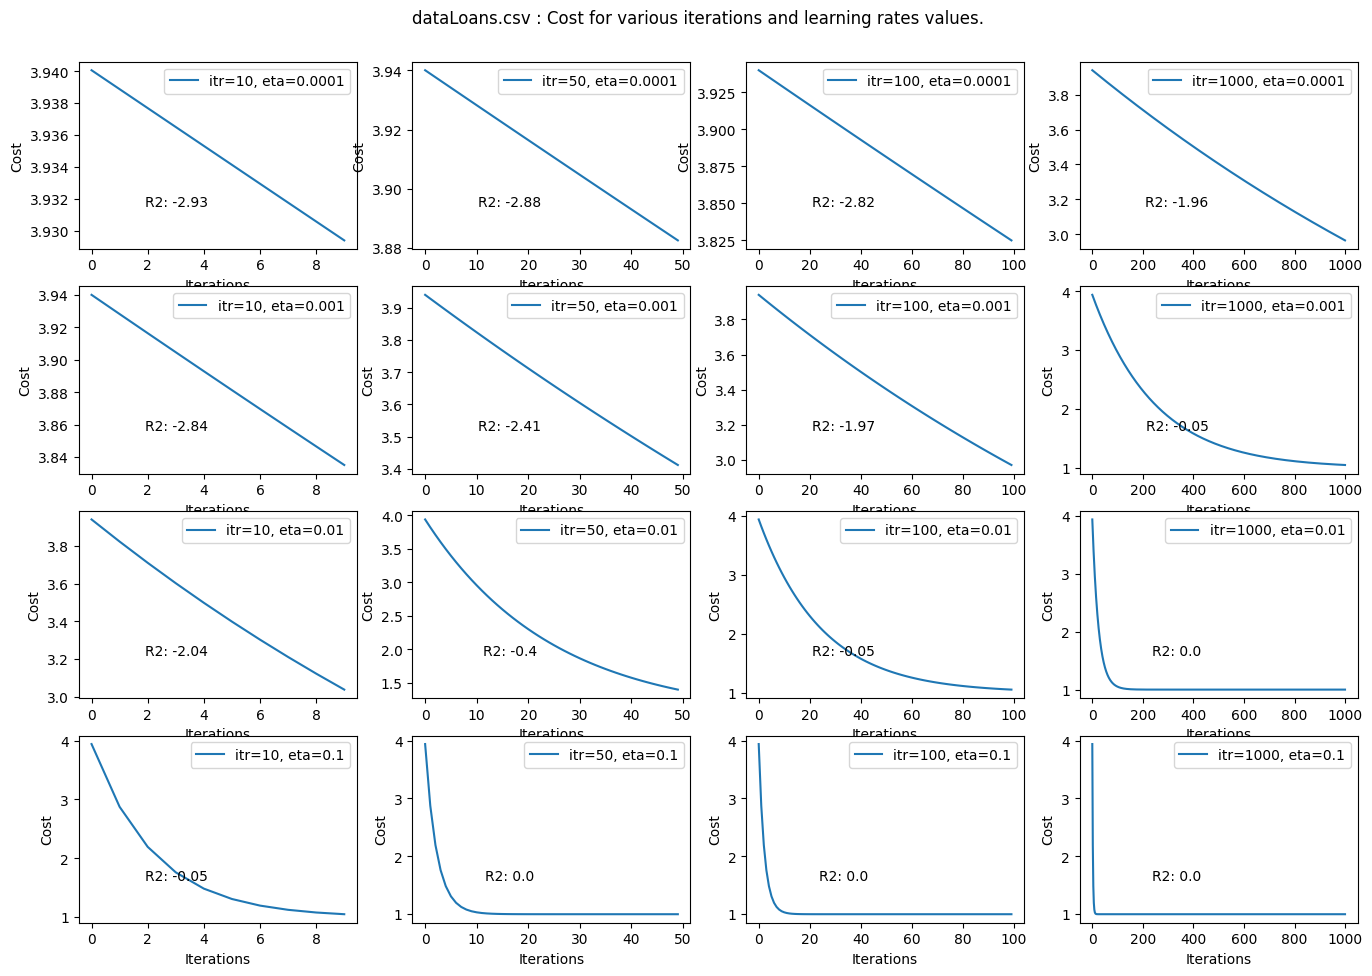

In [341]:
for file in files:
    mlr = MultiLinearRegression(file[0], file[1], file[2], 1000, 0.01)
    mlr.gradientDescent()
    # Plot cost for various iterations and learning rates values:
    plotMultiple(file[0], file[1], file[2], [10, 50, 100, 1000], [0.0001, 0.001, 0.01, 0.1])

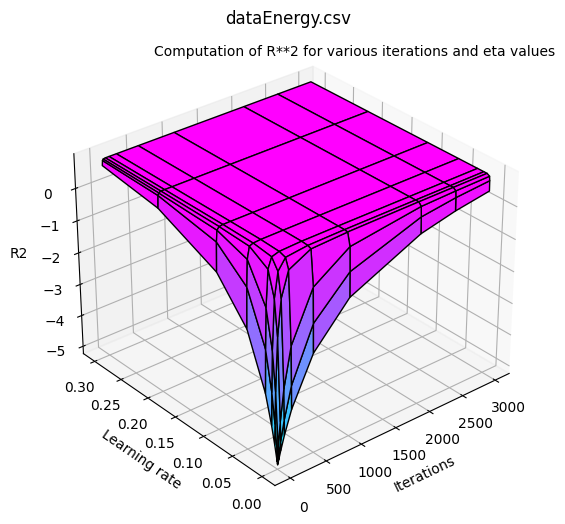

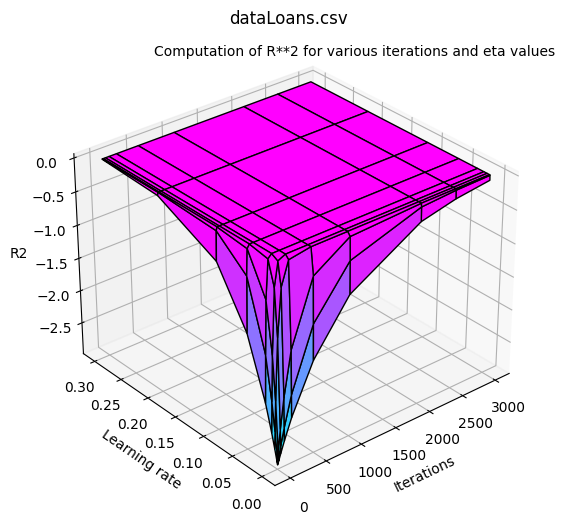

In [342]:
for file in files:
    mlr = MultiLinearRegression(file[0], file[1], file[2], 1000, 0.01)
    mlr.gradientDescent()
    # Plot R2 for various iterations and learning rates values:
    plot3D(file[0], file[1], file[2], [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 2500, 3000],
           [0.0003, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

In [343]:
# Compute max R2 for various iterations and learning rates values, at .01 % precision:
for file in files:
    printMaxR2(file[0], file[1], file[2], [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 2500, 3000],
               [0.0003, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3])

dataEnergy.csv : Max R2:  92.87  % (for itr= 2000 , and eta= 0.01 )
dataLoans.csv : Max R2:  0.09  % (for itr= 3000 , and eta= 0.001 )


In [344]:
# Table of R2 for various iterations and learning rates values:
for file in files:
    tableOfR2(file[0], file[1], file[2], [5, 10, 20, 50, 100, 200, 500, 1000, 2000, 2500], [0.0003, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3])
    print('\n')

dataEnergy.csv : Table of R2 for various iterations and learning rates values:
╒════════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤════════╤════════╕
│   LR \ ITR │       5 │      10 │      20 │      50 │     100 │     200 │     500 │    1000 │   2000 │   2500 │
╞════════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪════════╪════════╡
│     0.0003 │ -5.1163 │ -5.0683 │ -4.9738 │ -4.703  │ -4.2905 │ -3.5896 │ -2.1735 │ -0.9719 │ 0.0251 │ 0.2735 │
├────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────┼────────┤
│     0.0005 │ -5.0906 │ -5.0113 │ -4.8571 │ -4.4281 │ -3.8107 │ -2.8598 │ -1.2785 │ -0.2072 │ 0.5276 │ 0.67   │
├────────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────┼────────┤
│     0.001  │ -5.0269 │ -4.872  │ -4.5793 │ -3.821  │ -2.8665 │ -1.6705 │ -0.2081 │  0.5274 │ 0.8327 │ 0.866  │
├────────────┼───

In [345]:
# Table of iterations needed for convergence for various learning rates values:
for file in files:
    tableOfIterations(file[0], file[1], file[2], [0.0003, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3])
    print('\n')

dataEnergy.csv : Table of iterations needed for convergence, for various learning rates values:
╒═════════════════╤══════════════╕
│   Learning rate │   Iterations │
╞═════════════════╪══════════════╡
│          0.0003 │         9032 │
├─────────────────┼──────────────┤
│          0.0005 │         8234 │
├─────────────────┼──────────────┤
│          0.001  │         7073 │
├─────────────────┼──────────────┤
│          0.005  │         2977 │
├─────────────────┼──────────────┤
│          0.01   │         1826 │
├─────────────────┼──────────────┤
│          0.02   │         1081 │
├─────────────────┼──────────────┤
│          0.05   │          521 │
├─────────────────┼──────────────┤
│          0.1    │          293 │
├─────────────────┼──────────────┤
│          0.2    │          162 │
├─────────────────┼──────────────┤
│          0.3    │          114 │
╘═════════════════╧══════════════╛


dataLoans.csv : Table of iterations needed for convergence, for various learning rates values:
╒═

In [12]:
# Compute SKLearn R2, and print both computed and SKLearn R2:
for file in files:
    mlr = MultiLinearRegression(file[0], file[1], file[2], 1000, 0.01)
    mlr.gradientDescent()
    mlr.printR2()
    mlr.printSKLearnR2()

Computed R2 for the dataEnergy.csv data, in percentage:  92.63  %
SKLearn R2 for the dataEnergy.csv data, in percentage:  92.86  %
Computed R2 for the dataLoans.csv data, in percentage:  0.09  %
SKLearn R2 for the dataLoans.csv data, in percentage:  0.08  %


Since it seems there's a difference between the computed R2 and the SKLearn R2 for 1000 iterations and a learning rate of 0.01, it may be interesting to table difference between both R2 for various iterations and learning rates values.

In [347]:
# Table of difference between computed R2 and R2 using SKLearn, for various iterations and learning rates values:
for file in files:
    tableOfR2Diff(file[0], file[1], file[2], [5, 10, 20, 50, 100, 200, 500, 1000, 2000],
                  [0.0003, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3])
    print('\n')

dataEnergy.csv : Table of difference between computed R2 and SKlearn R2, for various iterations and learning rates values:
╒════════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤═════════╕
│   LR \ ITR │ 5        │ 10       │ 20       │ 50       │ 100      │ 200      │ 500      │ 1000     │ 2000    │
╞════════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╪═════════╡
│     0.0003 │ 600.33 % │ 596.91 % │ 587.98 % │ 560.89 % │ 519.64 % │ 449.55 % │ 307.94 % │ 187.79 % │ 88.08 % │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼─────────┤
│     0.0005 │ 599.13 % │ 592.18 % │ 577.07 % │ 534.17 % │ 472.43 % │ 377.34 % │ 219.21 % │ 112.08 % │ 38.6 %  │
├────────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼─────────┤
│     0.001  │ 594.03 % │ 579.25 % │ 550.06 % │ 474.24 % │ 378.79 % │ 259.18 % │ 112.9

To understand this, we may try to split our data into a training set and a test set, and compute the R2 for both sets.

In [14]:
# Gradient descent using multiples train and test sets:
for file in files:
    mlr = MultiLinearRegression(file[0], file[1], file[2], 1000, 0.01)
    costs, r2s, skr2s = [], [], 0
    for k in range(4):
        cost, r2, skr2 = mlr.gradientDescentMultipleTrainAndTestSets(0.2*(k+1))
        costs.append(cost)
        r2s.append(r2)
        skr2s += skr2
    r2 = np.max(r2s)
    skr2 = skr2s/4
    print(file[0], ': R2 = ', np.round(r2*100, 2), ' %')
    print(file[0], ': SKLearn R2 =  ', np.round(skr2*100, 2), ' %')


dataEnergy.csv : R2 =  92.68  %
dataEnergy.csv : SKLearn R2 =   92.97  %
dataLoans.csv : R2 =  -1.75  %
dataLoans.csv : SKLearn R2 =   0.72  %


Using multiples train and test sets, we can see that the R2 is very close to the SKLearn R2, which means that the gradient descent algorithm is working properly.
However, upon spliting the data into a training set and a test set, the average R2 value seems to be lower than the R2 value computed using the whole data set.
This may be due to the fact that the data set is not big enough, and that the training set is too small to be representative of the whole data set.


### CQFD